## Car Identification

The goals / steps of this project are the following:

* Import a set of car and noncar training images
* Determine the spatial, histogram, and HOG features of training data
* Train an SVM against that dataset
* Extract from the project video a series of test windows for each frame, at 128x128, 96x96, 64x64, 48x48, and 32x32
* Use the SVM against those windows, each scaled to 64x64 tiles 
* Build a heatmap of the windows thus flagged
* Remove any heatmap hits below a threshold
* Average the heatmaps over time to reduce outliers
* Draw a box around the identified cars, and output the resulting image

---
## First, import the libraries needed

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import pickle
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from collections import deque

## Then, define lesson code for functions to be used in processing features

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='LUV', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors

    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)

        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        ######added to test this NaN issue
        #print(hist_features)
        ######added to test this NaN issue
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      #was: hog_features.extend()
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #print(len(hog_features))  #base code is returning nan for many features; looks like the hog features on hog channel 2?
    #print(len(hist_features)) 
    #print(len(spatial_features)) 
    #9) Return concatenated array of features
    #print(np.concatenate(img_features).shape)
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #print(features)
        features = np.nan_to_num(features)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap,bbox_list):
    # Iterate through list of boxes
    for box in bbox_list:
        # Add +=1 for all pixels inside each box
        # Assuming each box takes the form ((x1,y1),(x2,y2))
        #heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return heatmap 
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_boxes(img, labels):
    # Iterate through all detected cars
    for car_num in range(1, labels[1]+1):
        # Find pixels with each car_num label value
        nonzero = (labels[0] == car_num).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        box = ((np.min(nonzerox),np.min(nonzeroy)),(np.max(nonzerox),np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, box[0], box[1], (255,0,0), 3) 
    # return image
    return img




In [ ]:
#testing
#import os
#images_path = os.listdir('*')
#print(len(images_path))
#images_path = glob.glob('trainingimages/*/*/*')
#print(len(images_path))

In [ ]:
#image = mpimg.imread('testimgs\\000275.png')
#plt.imshow(image)
#windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[150, None], 
#                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
#window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)    #plt.imshow(window_img)

# Train the model

In [ ]:
SKIP THIS, TRAINED MODEL IS GOOD
#Train the model
# Read in cars and notcars
images_path = glob.glob('trainingimgs/*/*/*')


#Break up the full dataset into the cars and notcars sets
cars = []
notcars = []
for image in images_path:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
print('Start the training')
#suffle the sets to avoice fitting on the order or a specific subset
np.random.shuffle(cars)
np.random.shuffle(notcars)
sample_size = 12000  #limit the model to a smaller portion of the data, because this laptop is weak
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### Set model parameters.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [390, 700] # Min and max in y to search in slide_window()
y_start_stop128 = [380, 680] # Min and max in y to search in slide_window()
y_start_stop64 = [390, 550] # Min and max in y to search in slide_window()

y_start_stop48 = [380, 475] # Min and max in y to search in slide_window()
y_start_stop32 = [380, 475] # Min and max in y to search in slide_window()


#y_start_stop128 = [370, 680] # Min and max in y to search in slide_window()
#y_start_stop64 = [390, 550] # Min and max in y to search in slide_window()
#y_start_stop32 = [390, 475] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
print('Shape of training data X is:',X.shape)
X = np.nan_to_num(X)
#The below is to try and resolve a bunch of NaN values which was returned by the extract features function.  For now, replacing NaN with 0 instead.
#bad_indices = np.where(np.isinf(X))
#print(bad_indices)
#bad_indices = np.where(np.isnan(X))
#print(bad_indices)

#Scale the result
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
print('scaled_X shape:',scaled_X.shape)
# Stack the labels
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('feature label y shape:',y.shape)
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

#print some feedback
print(orient,'orientations,',pix_per_cell,
    'pixels per cell,', cell_per_block,'cells per block')
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), ' seconds to train SVC')
print('Test Accuracy = ', round(svc.score(X_test, y_test), 4))

#save to pickle file
filename = 'svc_search_cars.p'
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins

#not included in pickle file:
#color_space=color_space, hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                        hist_feat=hist_feat, hog_feat=hog_feat
pickle.dump(dist_pickle, open(filename, 'wb'))
#filename.close()

print('Model saved')


# Load the model

In [3]:
print('Loading model...')
dist_pickle = pickle.load(open("svc_search_cars.p", "rb" ))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
#orient = dist_pickle["orient"]
#pix_per_cell = dist_pickle["pix_per_cell"]
#cell_per_block = dist_pickle["cell_per_block"]
#spatial_size = dist_pickle["spatial_size"]
#hist_bins = dist_pickle["hist_bins"]

#color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 11  # HOG orientations
#pix_per_cell = 8 # HOG pixels per cell
#cell_per_block = 2 # HOG cells per block
#hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
#spatial_size = (16,16)#(64, 64) # Spatial binning dimensions
#hist_bins = 32  #64    # Number of histogram bins
#spatial_feat = True # Spatial features on or off
#hist_feat = True # Histogram features on or off
#hog_feat = True # HOG features on or off
#y_start_stop = [390, 700] # Min and max in y to search in slide_window()

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16,16) # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop128 = [370, 680] # Min and max in y to search in slide_window()
y_start_stop64 = [390, 560] # Min and max in y to search in slide_window()
y_start_stop48 = [380, 475] # Min and max in y to search in slide_window()
y_start_stop32 = [380, 475] # Min and max in y to search in slide_window()
#y_start_stop24 = [390, 450] # Min and max in y to search in slide_window()

print('Done')

Loading model...
Done


# Test the model - test 1

Starting test...
21.84 Seconds to find cars


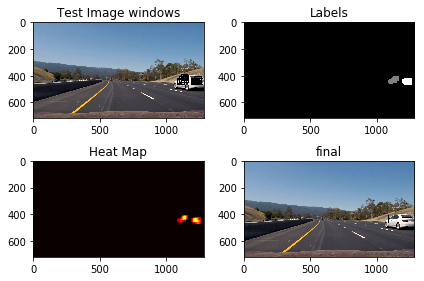

In [4]:
#Test model on sample frame from project video

#image = mpimg.imread('bbox-example-image.jpg')
#draw_image = np.copy(image)/255


print('Starting test...')
image = mpimg.imread('vidframe1495226891.5714326.png')
#image = mpimg.imread('vidframe1495172970.7389793.png')
#image = mpimg.imread('vidframe1495177279.8779733.png')

draw_image = np.copy(image)
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#draw_image = draw_image.astype(np.float32)
t=time.time()
windows = []
#windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
win128 = slide_window(draw_image, x_start_stop=[200, None], y_start_stop=y_start_stop128, 
                    xy_window=(128, 128), xy_overlap=(0.7, 0.7))
#win96 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop96, 
#                    xy_window=(96, 96), xy_overlap=(0.7, 0.7))
win64 = slide_window(draw_image, x_start_stop=[200, None], y_start_stop=y_start_stop64, 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7))
win48 = slide_window(draw_image, x_start_stop=[300, None], y_start_stop=y_start_stop48, 
                    xy_window=(48, 48), xy_overlap=(0.7, 0.7))
win32 = slide_window(draw_image, x_start_stop=[300, None], y_start_stop=y_start_stop32, 
                    xy_window=(32, 32), xy_overlap=(0.8, 0.8))
#win24 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                    xy_window=(24, 24), xy_overlap=(0.7, 0.7))

#find all possible windows and return a list of start/end coordinate
windows.extend(win128)
#windows.extend(win96)
windows.extend(win64)
windows.extend(win48)
windows.extend(win32)
#windows.extend(win24)
#find all possible windows and return a list of start/end coordinates
hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)     

#create a test output with all the candidate windows drawn in
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)

#Build heatmap using add_heat()
heat = np.zeros_like(image[:,:,0])
heat = add_heat(heat,hot_windows)
heat = apply_threshold(heat,1)
heatmap = np.clip(heat, 0, 255)

#label the thresholded heat map
labels = label(heatmap)

#overlay the labels onto the original image
draw_img = draw_labeled_boxes(np.copy(image), labels)


cv2.imwrite('OUTPUT_IMAGES/vidframe1495226891.5714326.png',cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to find cars')
fig = plt.figure()
plt.subplot(221)
aa=plt.imshow(window_img)
plt.title('Test Image windows')
plt.subplot(222)
#ab=plt.imshow(draw_img)
ab = plt.imshow(labels[0], cmap='gray')
plt.title('Labels')
plt.subplot(223)
cd=plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(224)
ef=plt.imshow(draw_img)
plt.title('final')
fig.tight_layout()
plt.show(fig)

# Test the model - test 2

Start test 2...
29.81 Seconds to find cars


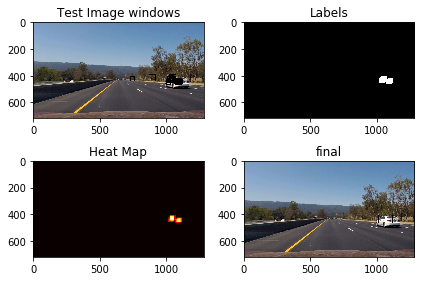

In [5]:
#Test model on sample frame from project video

print('Start test 2...')
#image = mpimg.imread('vidframe1495226891.5714326.png')
image = mpimg.imread('vidframe1495172970.7389793.png')
#image = mpimg.imread('vidframe1495177279.8779733.png')

draw_image = np.copy(image)
#print(image)
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#draw_image = draw_image.astype(np.float32)
t=time.time()
windows = []
#windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
win128 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop128, 
                    xy_window=(128, 128), xy_overlap=(0.7, 0.7))
#win96 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop96, 
#                    xy_window=(96, 96), xy_overlap=(0.7, 0.7))
win64 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop64, 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7))
win48 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop48, 
                    xy_window=(48, 48), xy_overlap=(0.7, 0.7))
win32 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop32, 
                    xy_window=(32, 32), xy_overlap=(0.8, 0.8))
#win24 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                    xy_window=(24, 24), xy_overlap=(0.7, 0.7))

#find all possible windows and return a list of start/end coordinate
windows.extend(win128)
#windows.extend(win96)
windows.extend(win64)
windows.extend(win48)
windows.extend(win32)
#windows.extend(win24)
#find all possible windows and return a list of start/end coordinates
hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)     

#create a test output with all the candidate windows drawn in
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)

#Build heatmap using add_heat()
heat = np.zeros_like(image[:,:,0])
heat = add_heat(heat,hot_windows)
heat = apply_threshold(heat,1)
heatmap = np.clip(heat, 0, 255)

#label the thresholded heat map
labels = label(heatmap)

#overlay the labels onto the original image
draw_img = draw_labeled_boxes(np.copy(image), labels)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to find cars')
fig = plt.figure()
plt.subplot(221)
aa=plt.imshow(window_img)
plt.title('Test Image windows')
plt.subplot(222)
#ab=plt.imshow(draw_img)
ab = plt.imshow(labels[0], cmap='gray')
plt.title('Labels')
plt.subplot(223)
cd=plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(224)
ef=plt.imshow(draw_img)
plt.title('final')
fig.tight_layout()
plt.show(fig)

# Test the model - test 3 (all test images)

In [ ]:
#Test model on test frames

print('Start test 3...')
image1 = mpimg.imread('test_images\\test1.jpg')
image2 = mpimg.imread('test_images\\test2.jpg')
image3 = mpimg.imread('test_images\\test3.jpg')
image4 = mpimg.imread('test_images\\test4.jpg')
image5 = mpimg.imread('test_images\\test5.jpg')
image6 = mpimg.imread('test_images\\test6.jpg')

draw_image1 = np.copy(image1)
draw_image1 = np.copy(image1)/255
draw_image1 = draw_image1.astype(np.float32)
draw_image2 = np.copy(image2)
draw_image2 = np.copy(image2)/255
draw_image2 = draw_image2.astype(np.float32)
draw_image3 = np.copy(image3)
draw_image3 = np.copy(image3)/255
draw_image3 = draw_image3.astype(np.float32)
draw_image4 = np.copy(image4)
draw_image4 = np.copy(image4)/255
draw_image4 = draw_image4.astype(np.float32)
draw_image5 = np.copy(image5)
draw_image5 = np.copy(image5)/255
draw_image5 = draw_image5.astype(np.float32)
draw_image6 = np.copy(image6)
draw_image6 = np.copy(image6)/255
draw_image6 = draw_image6.astype(np.float32)

t=time.time()
windows = []
#windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))
win128 = slide_window(draw_image, x_start_stop=[200, None], y_start_stop=y_start_stop128, 
                    xy_window=(128, 128), xy_overlap=(0.7, 0.7))
#win96 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop96, 
#                    xy_window=(96, 96), xy_overlap=(0.7, 0.7))
win64 = slide_window(draw_image, x_start_stop=[200, None], y_start_stop=y_start_stop64, 
                    xy_window=(64, 64), xy_overlap=(0.7, 0.7))
win48 = slide_window(draw_image, x_start_stop=[300, None], y_start_stop=y_start_stop48, 
                    xy_window=(48, 48), xy_overlap=(0.7, 0.7))
win32 = slide_window(draw_image, x_start_stop=[360, None], y_start_stop=y_start_stop32, 
                    xy_window=(32, 32), xy_overlap=(0.8, 0.8))
#win24 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                    xy_window=(24, 24), xy_overlap=(0.7, 0.7))

#find all possible windows and return a list of start/end coordinate
windows.extend(win128)
#windows.extend(win96)
windows.extend(win64)
windows.extend(win48)
windows.extend(win32)
#windows.extend(win24)
#find all possible windows and return a list of start/end coordinates
hot_windows1 = search_windows(draw_image1, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)     

#1 create a test output with all the candidate windows drawn in
window_img1 = draw_boxes(image1, hot_windows1, color=(0, 0, 255), thick=6)

#Build heatmap using add_heat()
heat1 = np.zeros_like(image1[:,:,0])
heat1 = add_heat(heat1,hot_windows1)
heat1 = apply_threshold(heat1,1)
heatmap1 = np.clip(heat1, 0, 255)

#label the thresholded heat map
labels1 = label(heatmap1)

#overlay the labels onto the original image
draw_img1 = draw_labeled_boxes(np.copy(image1), labels1)

fig = plt.figure()
plt.subplot(331)
aa=plt.imshow(window_img1)
plt.title('Test Image windows')
plt.subplot(332)
ba=plt.imshow(heatmap1, cmap='hot')
plt.title('Heat Map')
plt.subplot(333)
ca = plt.imshow(labels1[0], cmap='gray')
plt.title('Labels')

##2##
#find all possible windows and return a list of start/end coordinates
hot_windows2 = search_windows(draw_image2, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

#create a test output with all the candidate windows drawn in
window_img2 = draw_boxes(image2, hot_windows2, color=(0, 0, 255), thick=6)

#Build heatmap using add_heat()
heat2 = np.zeros_like(image2[:,:,0])
heat2 = add_heat(heat2,hot_windows2)
heat2 = apply_threshold(heat2,1)
heatmap2 = np.clip(heat2, 0, 255)

#label the thresholded heat map
labels2 = label(heatmap2)

#overlay the labels onto the original image
draw_img2 = draw_labeled_boxes(np.copy(image2), labels2)

plt.subplot(334)
ab=plt.imshow(window_img2)
plt.title('Test Image windows')
plt.subplot(335)
bb=plt.imshow(heatmap2, cmap='hot')
plt.title('Heat Map')
plt.subplot(336)
cb = plt.imshow(labels2[0], cmap='gray')
plt.title('Labels')

##3##
#find all possible windows and return a list of start/end coordinates
hot_windows3 = search_windows(draw_image3, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

#create a test output with all the candidate windows drawn in
window_img3 = draw_boxes(image3, hot_windows3, color=(0, 0, 255), thick=6)

#Build heatmap using add_heat()
heat3 = np.zeros_like(image3[:,:,0])
heat3 = add_heat(heat3,hot_windows3)
heat3 = apply_threshold(heat3,1)
heatmap3 = np.clip(heat3, 0, 255)

#label the thresholded heat map
labels3 = label(heatmap3)

#overlay the labels onto the original image
draw_img3 = draw_labeled_boxes(np.copy(image3), labels3)

plt.subplot(337)
ac=plt.imshow(window_img3)
plt.title('Test Image windows')
plt.subplot(338)
bc=plt.imshow(heatmap3, cmap='hot')
plt.title('Heat Map')
plt.subplot(339)
cc = plt.imshow(labels3[0], cmap='gray')
plt.title('Labels')

fig.tight_layout()
plt.show(fig)

##4##
#find all possible windows and return a list of start/end coordinates
hot_windows4 = search_windows(draw_image4, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)     

#create a test output with all the candidate windows drawn in
window_img4 = draw_boxes(image4, hot_windows4, color=(0, 0, 255), thick=6)

#Build heatmap using add_heat()
heat4 = np.zeros_like(image4[:,:,0])
heat4 = add_heat(heat4,hot_windows4)
heat4 = apply_threshold(heat4,1)
heatmap4 = np.clip(heat4, 0, 255)

#label the thresholded heat map
labels4 = label(heatmap4)

#overlay the labels onto the original image
draw_img4 = draw_labeled_boxes(np.copy(image4), labels4)

fig = plt.figure()
plt.subplot(331)
aa=plt.imshow(window_img4)
plt.title('Test Image windows')
plt.subplot(332)
ba=plt.imshow(heatmap4, cmap='hot')
plt.title('Heat Map')
plt.subplot(333)
ca = plt.imshow(labels4[0], cmap='gray')
plt.title('Labels')

##5##
#find all possible windows and return a list of start/end coordinates
hot_windows5 = search_windows(draw_image5, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

#create a test output with all the candidate windows drawn in
window_img5 = draw_boxes(image5, hot_windows5, color=(0, 0, 255), thick=6)

#Build heatmap using add_heat()
heat5 = np.zeros_like(image5[:,:,0])
heat5 = add_heat(heat5,hot_windows5)
heat5 = apply_threshold(heat5,1)
heatmap5 = np.clip(heat5, 0, 255)

#label the thresholded heat map
labels5 = label(heatmap5)

#overlay the labels onto the original image
draw_img5 = draw_labeled_boxes(np.copy(image5), labels5)

plt.subplot(334)
ab=plt.imshow(window_img5)
plt.title('Test Image windows')
plt.subplot(335)
bb=plt.imshow(heatmap5, cmap='hot')
plt.title('Heat Map')
plt.subplot(336)
cb = plt.imshow(labels5[0], cmap='gray')
plt.title('Labels')

##6##
#find all possible windows and return a list of start/end coordinates
hot_windows6 = search_windows(draw_image6, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

#create a test output with all the candidate windows drawn in
window_img6 = draw_boxes(image6, hot_windows6, color=(0, 0, 255), thick=6)

#Build heatmap using add_heat()
heat6 = np.zeros_like(image6[:,:,0])
heat6 = add_heat(heat6,hot_windows6)
heat6 = apply_threshold(heat6,1)
heatmap6 = np.clip(heat6, 0, 255)

#label the thresholded heat map
labels6 = label(heatmap6)

#overlay the labels onto the original image
draw_img6 = draw_labeled_boxes(np.copy(image6), labels6)

plt.subplot(337)
ac=plt.imshow(window_img6)
plt.title('Test Image windows')
plt.subplot(338)
bc=plt.imshow(heatmap6, cmap='hot')
plt.title('Heat Map')
plt.subplot(339)
cc = plt.imshow(labels6[0], cmap='gray')
plt.title('Labels')

fig.tight_layout()
plt.show(fig)

print('End test 3.')

In [ ]:
cv2.imwrite('examples/finaltestBoxes.png',cv2.cvtColor(draw_img6, cv2.COLOR_BGR2RGB))

In [ ]:
cv2.imwrite('output_images/outputtest1.png',cv2.cvtColor(draw_img1, cv2.COLOR_BGR2RGB))
cv2.imwrite('output_images/outputtest2.png',cv2.cvtColor(draw_img2, cv2.COLOR_BGR2RGB))
cv2.imwrite('output_images/outputtest3.png',cv2.cvtColor(draw_img3, cv2.COLOR_BGR2RGB))
cv2.imwrite('output_images/outputtest4.png',cv2.cvtColor(draw_img4, cv2.COLOR_BGR2RGB))
cv2.imwrite('output_images/outputtest5.png',cv2.cvtColor(draw_img5, cv2.COLOR_BGR2RGB))
cv2.imwrite('output_images/outputtest6.png',cv2.cvtColor(draw_img6, cv2.COLOR_BGR2RGB))

# Process the project video in the same manner as the above

In [6]:
print('Start video processing...')

def process_image(image):
    t=time.time
    # handle video range as 0..255 instead o 0..1:  
    draw_image = np.copy(image)/255
    #draw_image = np.copy(image)
    #draw_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    heatmaps = []
    heatmaps = deque(maxlen=10)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    draw_image = draw_image.astype(np.float32)
    t2=time.time()
    windows = []
    win128 = slide_window(draw_image, x_start_stop=[200, None], y_start_stop=y_start_stop128, 
                    xy_window=(128, 128), xy_overlap=(0.7, 0.8))
#    win96 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop96, 
#                    xy_window=(96, 96), xy_overlap=(0.8, 0.8))
    win64 = slide_window(draw_image, x_start_stop=[200, None], y_start_stop=y_start_stop64, 
                    xy_window=(64, 64), xy_overlap=(0.8, 0.8))
    win48 = slide_window(draw_image, x_start_stop=[300, None], y_start_stop=y_start_stop48, 
                    xy_window=(48, 48), xy_overlap=(0.7, 0.7))
    win32 = slide_window(draw_image, x_start_stop=[360, None], y_start_stop=y_start_stop32, 
                    xy_window=(32, 32), xy_overlap=(0.7, 0.7))
#    win24 = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=y_start_stop24, 
#                    xy_window=(24, 24), xy_overlap=(0.7, 0.7))

    #find all possible windows and return a list of start/end coordinate
    windows.extend(win128)
#    windows.extend(win96)
    windows.extend(win64)
    windows.extend(win48)
    windows.extend(win32)
#    windows.extend(win24)
    
    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    #Test heatmap without averaging
    #heat = np.zeros_like(image[:,:,0])#.astype(np.float)
    #heat = add_heat(heat, hot_windows)
    #heat = apply_threshold(heat,3)
    #heatmap = np.clip(heat, 0, 255)

    #labels = label(heatmap)
    #draw_image = draw_labeled_boxes(np.copy(image), labels)
    
    win_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
    heat = np.zeros_like(image[:,:,0]).astype(np.float32)
    avg_heat = heat
    if len(heatmaps) == 0:  #if the deque is empty, start it off with a blank slate to reduce the impact of false positives
        heatmaps.append(np.zeros_like(image[:,:,0]).astype(np.float32))#1
        heatmaps.append(np.zeros_like(image[:,:,0]).astype(np.float32))#2
        heatmaps.append(np.zeros_like(image[:,:,0]).astype(np.float32))#3
        heatmaps.append(np.zeros_like(image[:,:,0]).astype(np.float32))#4
        heatmaps.append(np.zeros_like(image[:,:,0]).astype(np.float32))#5
        heatmaps.append(np.zeros_like(image[:,:,0]).astype(np.float32))#6
        heatmaps.append(np.zeros_like(image[:,:,0]).astype(np.float32))#7
        heatmaps.append(np.zeros_like(image[:,:,0]).astype(np.float32))#8
        heatmaps.append(np.zeros_like(image[:,:,0]).astype(np.float32))#9
        heatmaps.append(np.zeros_like(image[:,:,0]).astype(np.float32))#10
    
    #cv2.imwrite('detectedimgs/vidframe'+str(t)+'w.png',cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB))
    #cv2.imwrite('detectedimgs/vidframe'+str(t)+'h.png',heatmap)
    #cv2.imwrite('detectedimgs/vidframe'+str(t)+'.png',cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB))
    #cv2.imwrite('origimgs/vidframe'+str(t)+'.png',image)#cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    global heatmaps

    
    if len(hot_windows) > 0:
        #print('initial heat, should be 0:', str(sum(sum(heat))))


        heat = add_heat(heat, hot_windows)
        heat = apply_threshold(heat,1) #8 worked well on the test image with 128, 96, 64 and 32 window sizes, but 6 seems better in video tests for some reason

        #test why the heatmap averaging isn't working with the initial blank frames
        #plt.subplot(332)
        #ab=plt.imshow(heatmaps[0], cmap='hot')
        #plt.title('Heat Map1')
        #plt.subplot(933)
        #ac=plt.imshow(heat, cmap='hot')
        #plt.title('Heat Map2')
        #plt.subplot(934)
        #ad=plt.imshow(heat, cmap='hot')
        #plt.title('Heat Map3')
        #plt.subplot(935)
        #ae=plt.imshow(heat, cmap='hot')
        #plt.title('Heat Map4')
        #plt.subplot(936)
        #af=plt.imshow(heat, cmap='hot')
        #plt.title('Heat Map5')
        #plt.subplot(333)
        #ag=plt.imshow(heatmaps[4], cmap='hot')
        #plt.title('Heat Map6')
        #plt.subplot(938)
        #ah=plt.imshow(heat, cmap='hot')
        #plt.title('Heat Map7')
        #plt.subplot(939)
        #ai=plt.imshow(heat, cmap='hot')
        #plt.title('Heat Map8')
        #plt.subplot(941)
        #aj=plt.imshow(heat, cmap='hot')
        #plt.title('Heat Map9')
        #plt.subplot(334)
        #ak=plt.imshow(heatmaps[9], cmap='hot')
        #plt.title('Heat Map10')
        
        heatmaps.append(heat)
        # average last 10 heat results
        #if len(heatmaps) >= 1:
        avg_heat = sum(heatmaps)/len(heatmaps)
        #print((sum(heatmaps)))
        heatmap = np.clip(avg_heat, 0, 255)
            
        #plt.subplot(335)
        #cd=plt.imshow(heatmap, cmap='hot')
        #plt.title('Avg Heat Map')
        

        labels = label(heatmap)
        draw_image = draw_labeled_boxes(np.copy(image), labels)
    else:
        draw_image = np.copy(image)
    
#watch the process work
#    fig = plt.figure()
#    plt.subplot(221)
#    aa=plt.imshow(win_img)
    #aa=plt.imshow(image)
#    plt.title('Image hot windows')
    
#    plt.subplot(222)
#    ac=plt.imshow(avg_heat, cmap='hot')
#    plt.title('Heat Map')
        
    #plt.subplot(223)
    #cd = plt.imshow(labels[0], cmap='gray')
    #plt.title('Labels')
#    plt.subplot(223)
#    cd = plt.imshow(heatmaps[9], cmap='hot')
#    plt.title('Heat Map newest')
#    plt.subplot(224)
#    ef=plt.imshow(draw_image)
#    plt.title('Final')
#    fig.tight_layout()
#    plt.show(fig)

    return draw_image


#clip1 = VideoFileClip("project_video.mp4").subclip(4,4.5)
clip1 = VideoFileClip("project_video.mp4")
video_output = 'result.mp4'
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
video_clip.write_videofile(video_output, audio=False)

Start video processing...
[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|███████████████████████████████████▉| 1260/1261 [6:24:05<00:16, 16.91s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 



# Further testing and writeup output image creation:

In [ ]:
fig = plt.figure()
plt.subplot(221)
aa=plt.imshow(window_img1)
#aa=plt.imshow(image)
plt.title('Image hot windows ex1')
    
plt.subplot(222)
ab=plt.imshow(window_img2)
#aa=plt.imshow(image)
plt.title('Image hot windows ex2')
    
plt.subplot(223)
aa=plt.imshow(window_img3)
#aa=plt.imshow(image)
plt.title('Image hot windows ex3')
    
plt.subplot(224)
aa=plt.imshow(window_img6)
#aa=plt.imshow(image)
plt.title('Image hot windows ex4')
    
fig.tight_layout()
plt.show(fig)

In [ ]:

images_path = glob.glob('trainingimgs/*/*/*')
cars = []
notcars = []
for image in images_path:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)
#suffle the sets to avoice fitting on the order or a specific subset
np.random.shuffle(cars)
np.random.shuffle(notcars)
sample_size = 12000  #limit the model to a smaller portion of the data, because this laptop is weak
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

In [ ]:
hog_test_img = cv2.cvtColor(mpimg.imread(cars[0]), cv2.COLOR_RGB2YCrCb)
features, hog_image = get_hog_features(hog_test_img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

features1, hog_image1 = get_hog_features(hog_test_img[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

features2, hog_image2 = get_hog_features(hog_test_img[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)
plt.figure(figsize=(40,40))
plt.subplot(161)
plt.title('Original Image')
plt.imshow(mpimg.imread(cars[0]))
plt.subplot(162)
plt.title('hog Ch0')
plt.imshow(hog_image)
plt.subplot(163)
plt.title('hog Ch1')
plt.imshow(hog_image1)
plt.subplot(164)
plt.title('hog Ch1')
plt.imshow(hog_image2)